# 1) Imports y configuración

In [1]:
import os, random, math
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
SEED       = 42
IMG_SIZE   = 160         # 128–224 suele ir bien; 160 es un buen equilibrio
BATCH_SIZE = 64
EPOCHS     = 200
DATA_DIR   = r'C:/Users/sebas/OneDrive/Desktop/ProyectoIA/UTKFace'   # carpeta con imágenes (UTKFace-like)
VAL_SPLIT  = 0.10
TEST_SPLIT = 0.10

In [3]:
random.seed(SEED)
tf.random.set_seed(SEED)

# 2) Utilidades: parsear edad e imagen

In [4]:
def parse_age_from_filename(path):
    """
    Para UTKFace: el nombre empieza con la edad, p. ej. '23_0_0_20170109150557335.jpg'
    Ajusta esto si tu dataset es distinto.
    """
    fname = tf.strings.split(path, os.sep)[-1]          # basename
    age_str = tf.strings.split(fname, "_")[0]           # '23'
    age = tf.strings.to_number(age_str, out_type=tf.float32)
    return age

In [5]:
def load_and_preprocess(path):
    img_bytes = tf.io.read_file(path)
    # UTKFace suele ser JPG; si tienes PNG usa decode_png
    img = tf.io.decode_jpeg(img_bytes, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    age = parse_age_from_filename(path)
    return img, age

# 3) Listado y split de archivos

In [6]:
all_files = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    all_files += list(Path(DATA_DIR).glob(ext))
all_files = [str(p) for p in all_files]
if not all_files:
    raise RuntimeError("No se encontraron imágenes. Revisa DATA_DIR y extensiones.")

In [7]:
random.shuffle(all_files)
N = len(all_files)
n_test = int(N * TEST_SPLIT)
n_val  = int(N * VAL_SPLIT)
n_train = N - n_val - n_test

In [8]:
train_files = all_files[:n_train]
val_files   = all_files[n_train:n_train+n_val]
test_files  = all_files[n_train+n_val:]

In [9]:
print(f"Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

Train: 18968 | Val: 2370 | Test: 2370


# 4) tf.data pipelines con augmentations

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

data_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augment")

def make_ds(filepaths, training):
    ds = tf.data.Dataset.from_tensor_slices(filepaths)
    ds = ds.shuffle(buffer_size=min(len(filepaths), 2000), seed=SEED) if training else ds
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augment(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_files, training=True)
val_ds   = make_ds(val_files, training=False)
test_ds  = make_ds(test_files, training=False)

# 5) Modelo: CNN residual ligera para regresión

In [11]:
def conv_bn_act(x, filters, k=3, s=1):
    x = layers.Conv2D(filters, k, strides=s, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    return x

def residual_block(x, filters, stride=1):
    shortcut = x
    x = conv_bn_act(x, filters, 3, stride)
    x = conv_bn_act(x, filters, 3, 1)
    # Proyección si cambia canales o stride
    if shortcut.shape[-1] != filters or stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation("swish")(x)
    return x

def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = keras.Input(shape=input_shape)
    # Stem
    x = conv_bn_act(inputs, 32, 3, 2)
    x = residual_block(x, 32, 1)
    x = residual_block(x, 32, 1)

    # Downsample + bloques
    x = residual_block(x, 64, 2)
    x = residual_block(x, 64, 1)

    x = residual_block(x, 128, 2)
    x = residual_block(x, 128, 1)
    x = residual_block(x, 128, 1)

    x = residual_block(x, 256, 2)
    x = residual_block(x, 256, 1)

    # Cabeza
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation="swish")(x)
    x = layers.Dropout(0.2)(x)
    # Salida: una sola neurona lineal (años)
    outputs = layers.Dense(1, activation="linear", dtype="float32")(x)  # fuerza float32 si usas mixed precision

    model = keras.Model(inputs, outputs, name="AgeRegressorCNN")
    return model

model = build_model()
model.summary()

Model: "AgeRegressorCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 80, 80,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 80, 80,    │      9,216 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 80, 80,    │          0 │ activation_2[0][… │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 80, 80,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 80, 80,    │      9,216 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 80, 80,    │      9,216 │ activation_4[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_4[0][0]  

 Total params: 3,161,825 (12.06 MB)

 Trainable params: 3,156,513 (12.04 MB)

 Non-trainable params: 5,312 (20.75 KB)

# 6) Compilación, callbacks y entrenamiento

In [12]:
loss = keras.losses.Huber(delta=5.0)
metrics = [
    keras.metrics.MeanAbsoluteError(name="mae"),
    keras.metrics.RootMeanSquaredError(name="rmse"),
]

optimizer = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

ckpt_path = "best_age_model.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_mae", save_best_only=True, mode="min"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.5, patience=5, min_lr=1e-6, mode="min", verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_mae", patience=15, restore_best_weights=True, mode="min", verbose=1),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 972s 3s/step - loss: 58.7236 - mae: 14.0034 - rmse: 19.0581 - val_loss: 76.0428 - val_mae: 17.5707 - val_rmse: 22.5414 - learning_rate: 0.0010
Epoch 2/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 941s 3s/step - loss: 42.5878 - mae: 10.7109 - rmse: 14.8491 - val_loss: 47.7337 - val_mae: 11.7835 - val_rmse: 15.3484 - learning_rate: 0.0010
Epoch 3/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 939s 3s/step - loss: 32.9139 - mae: 8.6962 - rmse: 12.0169 - val_loss: 37.4495 - val_mae: 9.5787 - val_rmse: 13.7128 - learning_rate: 0.0010
Epoch 4/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 928s 3s/step - loss: 29.5997 - mae: 7.9966 - rmse: 11.1215 - val_loss: 43.8491 - val_mae: 10.9210 - val_rmse: 14.8077 - learning_rate: 0.0010
Epoch 5/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 930s 3s/step - loss: 27.7291 - mae: 7.6102 - rmse: 10.5710 - val_loss: 48.9562 - val_mae: 11.9671 - val_rmse: 16.9203 - learning_rate: 0.0010
Epoch 6/200
297/297 ━━━━━━━━━━━━━━━━━━━━ 931s 3s/step - loss: 26.2976 - mae: 7.2911 

# 7) Evaluación y guardado

In [13]:
print("Evaluando en test...")
test_metrics = model.evaluate(test_ds, verbose=0)
print(dict(zip(model.metrics_names, test_metrics))) 

Evaluando en test...
{'loss': 15.678214073181152, 'compile_metrics': 4.9071946144104}


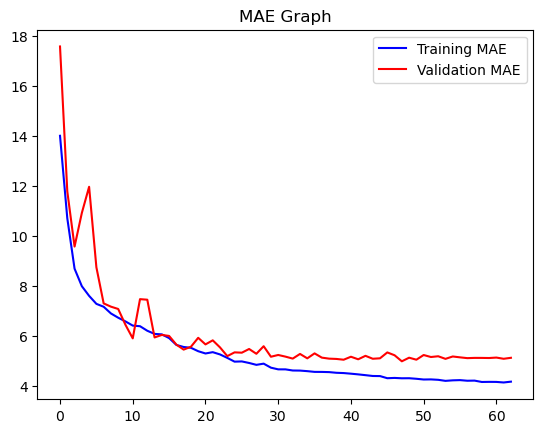

In [14]:
# plot results for age
import matplotlib.pyplot as plt
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('MAE Graph')
plt.legend()
plt.show()

In [15]:
def predict_age(image_path):
    img_bytes = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img_bytes, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)
    pred = model.predict(tf.expand_dims(img, 0), verbose=0)[0,0]
    return float(pred)

In [16]:
def true_age_from_path(p):
    # Para UTKFace: "23_0_0_....jpg"
    return float(os.path.basename(p).split("_")[0])

In [17]:
p = test_files[0]                     # o random.choice(test_files)
pred = predict_age(p)
print(os.path.basename(p), "→ pred =", pred, " | true =", true_age_from_path(p))

30_0_2_20170116170814123.jpg.chip.jpg → pred = 27.091142654418945  | true = 30.0


In [18]:
for p in random.sample(test_files, k=11):
    y_true = true_age_from_path(p)
    y_pred = predict_age(p)
    print(f"{os.path.basename(p):32s} true={y_true:5.1f}  pred={y_pred:5.1f}  err={abs(y_pred-y_true):5.1f}")

65_0_2_20170112222023530.jpg.chip.jpg true= 65.0  pred= 78.2  err= 13.2
68_0_0_20170104213635701.jpg.chip.jpg true= 68.0  pred= 66.7  err=  1.3
28_1_2_20170116162739672.jpg.chip.jpg true= 28.0  pred= 35.0  err=  7.0
5_0_0_20170110213615044.jpg.chip.jpg true=  5.0  pred=  3.4  err=  1.6
61_0_3_20170104210003146.jpg.chip.jpg true= 61.0  pred= 42.0  err= 19.0
40_0_2_20170116192534886.jpg.chip.jpg true= 40.0  pred= 33.3  err=  6.7
5_1_0_20170109194058911.jpg.chip.jpg true=  5.0  pred=  2.7  err=  2.3
1_1_2_20161219204636789.jpg.chip.jpg true=  1.0  pred=  1.0  err=  0.0
29_1_1_20170116021333343.jpg.chip.jpg true= 29.0  pred= 32.2  err=  3.2
58_0_0_20170117191924885.jpg.chip.jpg true= 58.0  pred= 53.8  err=  4.2
31_0_3_20170104232355440.jpg.chip.jpg true= 31.0  pred= 27.9  err=  3.1


In [41]:
print(predict_age(r'C:/Users/sebas/OneDrive/Desktop/Cosas mias/Fotos de perfil/cropped-EDUAR  MACIAS  SANCHEZ  DIGITAL.jpg'))

18.9373722076416
